### Sachs data

[Sachs Protein Data](https://perso.univ-rennes1.fr/valerie.monbet/GM/Sachs.html)

In [2]:
#%pip install ../. 
#%pip install cdt
from cdt.data import load_dataset
import networkx as nx
import jax
import jax.numpy as jnp
import jax.random as random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

from vamsl.metrics import neg_ave_log_likelihood
from vamsl.utils import visualize_ground_truth

print(f"JAX backend: {jax.default_backend()}")
key=random.PRNGKey(343)

JAX backend: cpu


In [ ]:
# Load the graph and data
sachs_data, sachs_graph = load_dataset("sachs")

adjacency = jnp.array(nx.to_numpy_array(sachs_graph))
visualize_ground_truth(adjacency)

#num_rows = 853+902+911+723+810+799+848+913+707#+899+753+868+759+927
data = jnp.log(jnp.array(sachs_data)[0:853,:])
data = jnp.vstack([data, jnp.log(jnp.array(sachs_data)[853+902+911+723:853+902+911+723+810,:])])
indicator = jnp.array([0 if i<853 else 1 for i in range(1755)])

# Use only subset of data
N = 250
key, subk = random.split(key)
sample = jax.random.choice(subk, jnp.arange(data.shape[0]), shape=(N,), replace=False, axis=0)
data, indicator = data[sample], indicator[sample]

print('Data shape: \n', data.shape)

In [4]:
dataset = 'kornblau'
#dataset = 'iyer'

if dataset == 'kornblau':
    proteins = ['AKT', 'AKT.p308', 'AKT.p473', 'BAD', 'BAD.p112', 'BAD.p136', 'BAD.p155', 'BAX', 'BCL2', 'BCLXL', 'CCND1', 'GSK3', 'GSK3.p', 'MYC', 'PTEN', 'PTEN.p', 'TP53', 'XIAP']
    FAB_groups = ['M2', 'M4']#['M0', 'M1', 'M2', 'M4']

    kornblau_df = pd.read_excel('./Datasets/Kornblau et al. 2009.xls')
    kornblau_FAB_df = kornblau_df[proteins][kornblau_df['FAB'].isin(FAB_groups)]
    data = kornblau_FAB_df.values
    indicator = kornblau_df['FAB'][kornblau_df['FAB'].isin(FAB_groups)].astype('category').cat.codes.values
    #[kornblau_FAB_df.hist(prot) for prot in proteins] # plot protein histograms
    
elif dataset == 'iyer':
    iyer_df = pd.read_html((file:='./Datasets/Iyer et al. 1999 - stripped.htm'), header=0)[0][[*pd.read_html(file, header=0)[0].columns[5:16]]]
    data = iyer_df.values
    #[iyer_df.hist(col) for col in iyer_df.cols] # plot protein histograms

In [9]:
# Process data
key, subk = random.split(key)
observed = random.bernoulli(subk, p=jnp.float32(0.8), shape=(data.shape[0],))

X, X_lo = data[observed], data[~observed]
sc =  StandardScaler()
X, X_lo = sc.fit_transform(X), sc.transform(X_lo)

X_indicator, X_lo_indicator = indicator[observed], indicator[~observed]

print('Observed data shape: \n', X.shape)
print('Left-out data shape: \n', X_lo.shape)

Observed data shape: 
 (92, 18)
Left-out data shape: 
 (35, 18)


In [10]:
# Observed data set
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01
mean,2.253029e-15,-5.309762e-16,3.704766e-16,-1.384158e-15,-3.970254e-16,-8.121523e-16,2.033398e-15,5.654897e-15,2.292852e-15,6.709609e-16,-2.560754e-15,2.148040e-15,1.117464e-15,-4.054728e-16,1.236330e-15,3.598571e-15,-2.285611e-15,1.975322e-15
std,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00
min,-2.676363e+00,-1.664124e+00,-1.766485e+00,-2.585614e+00,-2.534489e+00,-2.639611e+00,-2.845548e+00,-2.472790e+00,-3.565280e+00,-2.076187e+00,-1.787166e+00,-3.001011e+00,-2.691461e+00,-2.385176e+00,-3.265247e+00,-2.716546e+00,-1.513740e+00,-2.189053e+00
25%,-5.288247e-01,-7.716828e-01,-7.089831e-01,-6.018815e-01,-7.085467e-01,-7.811015e-01,-6.976184e-01,-5.418395e-01,-6.194674e-01,-6.935238e-01,-5.955841e-01,-7.222243e-01,-6.414697e-01,-6.948456e-01,-5.884988e-01,-5.067975e-01,-6.665625e-01,-7.166581e-01
50%,-5.969977e-02,-1.645814e-01,-1.308073e-01,-4.445648e-02,-7.907613e-02,-2.189658e-04,-7.924774e-02,3.898176e-02,4.275741e-02,-5.171408e-02,-1.619314e-01,-4.893219e-02,-1.701493e-01,-7.846760e-02,1.477090e-01,3.428554e-02,-1.858846e-01,-8.756966e-02
75%,4.496640e-01,7.656004e-01,6.120723e-01,5.625272e-01,6.001609e-01,7.229543e-01,5.954765e-01,6.995140e-01,5.690816e-01,4.298317e-01,5.651564e-01,7.223995e-01,5.922114e-01,5.340595e-01,7.768874e-01,7.372384e-01,2.962520e-01,6.477266e-01
max,2.786954e+00,2.808915e+00,3.554083e+00,2.913900e+00,3.014735e+00,2.130744e+00,2.403153e+00,3.090859e+00,2.045529e+00,3.880044e+00,4.051580e+00,4.314225e+00,2.418361e+00,2.622432e+00,1.967016e+00,1.852461e+00,4.476083e+00,3.793297e+00


In [11]:
# Left-out data set
pd.DataFrame(X_lo).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,-0.068168,-0.047086,-0.271721,-0.010764,-0.117387,0.143858,-0.405909,-0.074556,0.133895,0.089220,-0.071600,0.041266,-0.619987,-0.169259,-0.153238,0.145333,0.050195,-0.455814
std,0.852268,1.101955,1.052590,1.152810,0.912579,1.153690,1.001973,1.209683,1.113467,1.436906,0.632524,1.053231,0.943288,0.986321,1.215183,1.091717,1.029160,1.118408
min,-1.923010,-1.801510,-1.908166,-1.886591,-2.010072,-2.186242,-2.530499,-3.849462,-2.732487,-1.872328,-1.451265,-1.809318,-3.247888,-1.670656,-3.281368,-2.039341,-1.511725,-2.338709
25%,-0.631240,-1.048411,-1.180673,-0.858800,-0.770402,-0.728512,-1.167846,-0.606429,-0.505667,-1.138973,-0.455587,-0.740604,-1.099731,-0.702302,-1.117713,-0.682462,-0.614434,-1.409214
50%,-0.002234,0.058130,-0.303127,-0.080908,-0.058365,0.333884,-0.432852,0.130319,0.223477,-0.394973,-0.254728,0.125424,-0.537437,-0.327279,-0.112969,0.307482,-0.149643,-0.504885
75%,0.594128,0.774213,0.388495,0.517475,0.490519,0.954707,0.253546,0.681395,0.789308,0.943443,0.390901,0.745857,-0.077452,0.237476,0.967356,1.035598,0.193488,0.483112
max,1.263059,2.208262,2.074796,3.445954,2.445008,2.537600,1.611094,2.182502,2.123748,3.125819,1.533450,2.180483,2.256892,3.243378,1.579670,2.089478,3.315606,1.897232


In [12]:
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import confusion_matrix

n_components = 2
random_state = 48

labels = BayesianGaussianMixture(n_components=n_components, random_state=random_state, verbose=1).fit_predict(X)
print("VGMM clustering:\n", confusion_matrix(X_indicator, labels), '\n')

lo_labels = BayesianGaussianMixture(n_components=n_components, random_state=random_state, verbose=1).fit(X).predict(X_lo)
print("VGMM left-out clustering:\n", confusion_matrix(X_lo_indicator, lo_labels))

#BayesianGaussianMixture(n_components=n_components, random_state=random_state).fit(X).covariances_

Initialization 0
Initialization converged: True
VGMM clustering:
 [[46  1]
 [45  0]] 

Initialization 0
Initialization converged: True
VGMM left-out clustering:
 [[21  0]
 [14  0]]


### Create VaMSL model

In [20]:
from vamsl.models.graph import ErdosReniDAGDistribution, ScaleFreeDAGDistribution, UniformDAGDistributionRejection
from vamsl.models import MixtureLinearGaussian, MixtureDenseNonlinearGaussian
from vamsl.models import LinearGaussian, DenseNonlinearGaussian
from vamsl.target import make_graph_model

# BN settings
n_vars = X.shape[1] # number of variables in each component BN
struct_eq_type = 'linear' # BN function class: 'linear' or 'nonlinear'
graph_type = 'er' # Random graph structure: 'sf' (scale-free) or 'er' (Erdos-Renyi)

# Derived variables
n_components = 1
linear = True if struct_eq_type == 'linear' else False

# Model specification 
if linear:
    graph_model = make_graph_model(n_vars=n_vars, graph_prior_str=graph_type, edges_per_node=2)
    lik = MixtureLinearGaussian(n_vars=n_vars, obs_noise=0.1)  
    component_lik = LinearGaussian(n_vars=n_vars, obs_noise=0.1)
else:
    graph_model = make_graph_model(n_vars=n_vars, graph_prior_str=graph_type, edges_per_node=2)
    lik = MixtureDenseNonlinearGaussian(n_vars=n_vars, obs_noise=0.1)  
    component_lik = DenseNonlinearGaussian(n_vars=n_vars, obs_noise=0.1, hidden_layers=(5,))

In [24]:
from vamsl.inference import VaMSL

# Create VaMSL and initialize posteriors
vamsl = VaMSL(x=X, graph_model=graph_model, mixture_likelihood_model=lik, component_likelihood_model=component_lik, n_mixture_grad_mc_samples=1)
key, subk = random.split(key)
vamsl.initialize_posteriors(key=subk, n_components=n_components, n_particles=10, linear=linear)#, init_q_c=jnp.exp(vamsl.get_posteriors()[2]))
#vamsl.set_E(jnp.array([adjacency]))

print('Posterior shapes:')
posts = vamsl.get_posteriors()
print('q_z:     ' + str(posts[0].shape)) # [n_components, n_particls, d, l, 2]
print('q_theta: ' + str(posts[1].shape)) if linear else print('q_theta: ' + str(len(posts[1]))) # leading dim of n_components
print('log_q_c: ' + str(posts[2].shape)) # [n_observations, n_components]
print('q_pi:    ' + str(posts[3].shape)) # [n_components,]

Posterior shapes:
q_z:     (1, 10, 18, 18, 2)
q_theta: (1, 10, 18, 18)
log_q_c: (92, 1)
q_pi:    (1,)


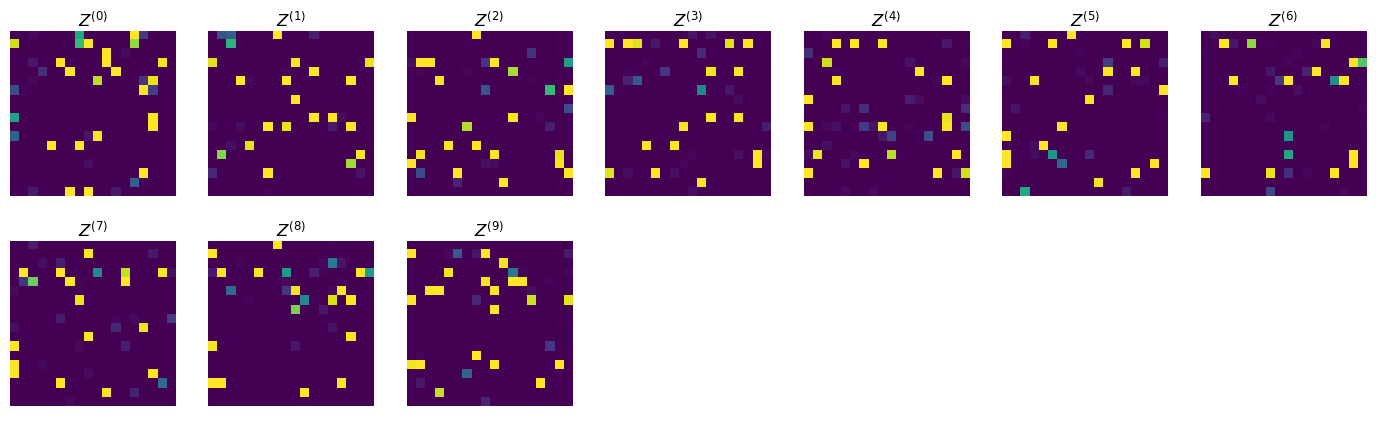

Component   1 | iteration 1000 | alpha   50.0 | beta 1000.0 | #cyclic   0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# CAVI and SVGD vars
n_cavi_updates, steps = 0, 200

# CAVI-loop
for cavi_update in range(n_cavi_updates):
    key, subk = random.split(key)
    # Optimize q(Z, \Theta)
    vamsl.update_particle_posteriors(key=subk, steps=steps, callback_every=steps,
                                     callback=vamsl.visualize_callback(), linear=linear)

    # Update to optimal q(c) and q(\pi)
    vamsl.update_responsibilities_and_weights()
    print(f'CAVI update number {cavi_update+1}/{n_cavi_updates}')
    
    # Print current clustering
    order = vamsl.identify_MAP_classification_ordering(ground_truth_indicator=indicator[observed])
    y_pred = [order[k] for k in [jnp.argmax(c_i) for c_i in vamsl.get_posteriors()[2]]]
    print('MAP clustering: \n', confusion_matrix(indicator[observed], y_pred))
    
# Final CAVI update with more SVGD steps to ensure annealing unto acyclic graphs
key, subk = random.split(key)
vamsl.update_particle_posteriors(key=subk, steps=3000, callback_every=200, callback=vamsl.visualize_callback(), linear=linear)
vamsl.update_responsibilities_and_weights()

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

X_indicator = indicator[observed]

print('Sums of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2]), axis=0))
print('Sum of entropy of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2])*vamsl.get_posteriors()[2]))
y_true, order = X_indicator, vamsl.identify_MAP_classification_ordering(ground_truth_indicator=X_indicator)
y_pred = [order[k] for k in [jnp.argmax(c_i) for c_i in vamsl.get_posteriors()[2]]]
if n_components==2:
    print('Classification report:')
    print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['Component 1', 'Component 2']))
print('Order: ', order)
print(confusion_matrix(y_true, y_pred))

Sums of responsibilities:
[51.866024 40.133976]
Sum of entropy of responsibilities:
-2.3791049
Classification report:
              precision    recall  f1-score   support

 Component 1       0.57      0.49      0.53        47
 Component 2       0.54      0.62      0.58        45

    accuracy                           0.55        92
   macro avg       0.56      0.56      0.55        92
weighted avg       0.56      0.55      0.55        92

Order:  [1 0]
[[23 24]
 [17 28]]


In [17]:
# BCD Nets
vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()

Array([0.5624045 , 0.43759552], dtype=float32)

In [18]:
# BCD Nets

# Calculate neg log liks for posterior assignment probabilities
mixing_probs = vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()
negll = 0
for i in range(X_lo.shape[0]):
    temp_negll = 0
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        temp_negll += mixing_probs[k] * neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
    negll += temp_negll
    
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

neg. LL 158.51


In [19]:
# BCD Nets

# Calculate neg log liks for MAP assignments 
negll = 0
rs = np.zeros((X_lo.shape[0], n_components))
for i in range(X_lo.shape[0]):
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        rs[i,k] = vamsl.compute_log_responsibility(X_lo[i,:].reshape((1,-1)), dist, vamsl.get_posteriors()[3][k])
        
    q_g_k = vamsl.particle_to_g_lim(vamsl.get_posteriors()[0][np.argmax(rs[i])], vamsl.get_E()[np.argmax(rs[i])])
    dist = vamsl.get_empirical(q_g_k, vamsl.get_posteriors()[1][np.argmax(rs[i])])
    negll += neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
print('held-out responsibilities:', -rs.sum(axis=0)/X_lo.shape[0])
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

held-out responsibilities: [155.65939331 163.74350542]
neg. LL 145.94


### Ground truth
0. linear (all data)
1. linear (500 datapoints)
2. non-linear (500 datapoints)

In [ ]:
# Loop over components and calculate metrics
for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate predictive density of left-out data
    negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo)/X_lo.shape[0]
    
    print(f'neg. LL {negll:5.2f}')

In [45]:
from vamsl.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

# Get component datasets
#datas = [X[(X_indicator==k).flatten(),:] for k in range(n_components)]

# Loop over components and calculate metrics
for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate metrics
    eshd = expected_shd(dist=dist, g=adjacency)       
    auroc = threshold_metrics(dist=dist, g=adjacency)['roc_auc']
    #negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=data.x_ho)
    
    print(f' Component {k+1:4d} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}')#    neg. LL {negll:5.2f}')

 Component    1 |  E-SHD: 17.7    AUROC:  0.57


In [12]:
# Loop over components and calculate metrics
for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate predictive density of left-out data
    negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo)/X_lo.shape[0]
    
    print(f'neg. LL {negll:5.2f}')

neg. LL 352.51


In [12]:
# Loop over components and calculate metrics
for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate predictive density of left-out data
    negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo)/X_lo.shape[0]
    
    print(f'neg. LL {negll:5.2f}')

neg. LL 351.96


In [24]:
# Loop over components and calculate metrics
for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate predictive density of left-out data
    negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo)/X_lo.shape[0]
    
    print(f'neg. LL {negll:5.2f}')

neg. LL  359.85845637583895


### One component

In [25]:
# BCD Nets data

# Loop over components and calculate metrics
for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate predictive density of left-out data
    negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo)/X_lo.shape[0]
    
    print(f'neg. LL {negll:5.2f}')

neg. LL 47.64


In [15]:
# Loop over components and calculate metrics
for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate predictive density of left-out data
    negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo)/X_lo.shape[0]
    
    print(f'neg. LL {negll:5.2f}')

neg. LL 42.38


In [16]:
# Loop over components and calculate metrics
for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate predictive density of left-out data
    negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo)/X_lo.shape[0]
    
    print(f'neg. LL {negll:5.2f}')

neg. LL 43.57


### Two components

In [10]:
# BCD Nets
vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()

Array([0.5950506 , 0.40494943], dtype=float32)

In [11]:
# BCD Nets

# Calculate neg log liks for posterior assignment probabilities
mixing_probs = vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()
negll = 0
for i in range(X_lo.shape[0]):
    temp_negll = 0
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        temp_negll += mixing_probs[k] * neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
    negll += temp_negll
    
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

neg. LL 60.48


In [12]:
# BCD Nets

# Calculate neg log liks for MAP assignments 
negll = 0
rs = np.zeros((X_lo.shape[0], n_components))
for i in range(X_lo.shape[0]):
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        rs[i,k] = vamsl.compute_log_responsibility(X_lo[i,:].reshape((1,-1)), dist, vamsl.get_posteriors()[3][k])
        
    q_g_k = vamsl.particle_to_g_lim(vamsl.get_posteriors()[0][np.argmax(rs[i])], vamsl.get_E()[np.argmax(rs[i])])
    dist = vamsl.get_empirical(q_g_k, vamsl.get_posteriors()[1][np.argmax(rs[i])])
    negll += neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
print('held-out responsibilities:', -rs.sum(axis=0)/X_lo.shape[0])
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

held-out responsibilities: [58.04676884 65.7165726 ]
neg. LL 53.45


In [19]:
vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()

Array([0.25614512, 0.7438549 ], dtype=float32)

In [20]:
# Calculate neg log liks for posterior assignment probabilities
mixing_probs = vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()
negll = 0
for i in range(X_lo.shape[0]):
    temp_negll = 0
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        temp_negll += mixing_probs[k] * neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
    negll += temp_negll
    
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

neg. LL 73.34


In [21]:
# Calculate neg log liks for MAP assignments 
negll = 0
rs = np.zeros((X_lo.shape[0], n_components))
for i in range(X_lo.shape[0]):
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        rs[i,k] = vamsl.compute_log_responsibility(X_lo[i,:].reshape((1,-1)), dist, vamsl.get_posteriors()[3][k])
        
    q_g_k = vamsl.particle_to_g_lim(vamsl.get_posteriors()[0][np.argmax(rs[i])], vamsl.get_E()[np.argmax(rs[i])])
    dist = vamsl.get_empirical(q_g_k, vamsl.get_posteriors()[1][np.argmax(rs[i])])
    negll += neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
print('held-out responsibilities:', -rs.sum(axis=0)/X_lo.shape[0])
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

held-out responsibilities: [72.10863315 74.53500079]
neg. LL 57.30


In [55]:
vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()

Array([0.09735344, 0.9026466 ], dtype=float32)

In [56]:
# Calculate neg log liks for posterior assignment probabilities
mixing_probs = vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()
negll = 0
for i in range(X_lo.shape[0]):
    temp_negll = 0
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        temp_negll += mixing_probs[k] * neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
    negll += temp_negll
    
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

neg. LL 53.15


In [57]:
# Calculate neg log liks for MAP assignments 
negll = 0
rs = np.zeros((X_lo.shape[0], n_components))
for i in range(X_lo.shape[0]):
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        rs[i,k] = vamsl.compute_log_responsibility(X_lo[i,:].reshape((1,-1)), dist, vamsl.get_posteriors()[3][k])
        
    q_g_k = vamsl.particle_to_g_lim(vamsl.get_posteriors()[0][np.argmax(rs[i])], vamsl.get_E()[np.argmax(rs[i])])
    dist = vamsl.get_empirical(q_g_k, vamsl.get_posteriors()[1][np.argmax(rs[i])])
    negll += neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
print('held-out responsibilities:', -rs.sum(axis=0)/X_lo.shape[0])
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

neg. LL 50.17


### Three components

In [61]:
vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()

Array([0.2916099 , 0.40393355, 0.30445644], dtype=float32)

In [62]:
# Calculate neg log liks for posterior assignment probabilities
mixing_probs = vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()
negll = 0
for i in range(X_lo.shape[0]):
    temp_negll = 0
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        temp_negll += mixing_probs[k] * neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
    negll += temp_negll
    
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

neg. LL 64.07


In [63]:
# Calculate neg log liks for MAP assignments 
negll = 0
rs = np.zeros((X_lo.shape[0], n_components))
for i in range(X_lo.shape[0]):
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        rs[i,k] = vamsl.compute_log_responsibility(X_lo[i,:].reshape((1,-1)), dist, vamsl.get_posteriors()[3][k])
        
    q_g_k = vamsl.particle_to_g_lim(vamsl.get_posteriors()[0][np.argmax(rs[i])], vamsl.get_E()[np.argmax(rs[i])])
    dist = vamsl.get_empirical(q_g_k, vamsl.get_posteriors()[1][np.argmax(rs[i])])
    negll += neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
print('held-out responsibilities:', -rs.sum(axis=0)/X_lo.shape[0])
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

neg. LL 53.65


### Four components

In [67]:
vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()

Array([0.07333528, 0.08092984, 0.550729  , 0.29500586], dtype=float32)

In [106]:
# Calculate neg log liks for posterior assignment probabilities
mixing_probs = vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()
negll = 0
for i in range(X_lo.shape[0]):
    temp_negll = 0
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        temp_negll += mixing_probs[k] * neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
    negll += temp_negll
    
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

neg. LL 59.32


In [105]:
# Calculate neg log liks for MAP assignments 
negll = 0
rs = np.zeros((X_lo.shape[0], n_components))
for i in range(X_lo.shape[0]):   
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        rs[i,k] = vamsl.compute_log_responsibility(X_lo[i,:].reshape((1,-1)), dist, vamsl.get_posteriors()[3][k])
        
    q_g_k = vamsl.particle_to_g_lim(vamsl.get_posteriors()[0][np.argmax(rs[i])], vamsl.get_E()[np.argmax(rs[i])])
    dist = vamsl.get_empirical(q_g_k, vamsl.get_posteriors()[1][np.argmax(rs[i])])
    negll += neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
print('held-out responsibilities:', -rs.sum(axis=0)/X_lo.shape[0])
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

held-out responsibilities: [77.87623398 74.46787088 54.27890074 63.65507151]
neg. LL 49.05


In [137]:
np.exp(rs - rs.sum(axis=1)[..., None]).sum(axis=0)

array([1.19552918e+240, 2.42086350e+254, 4.97122976e+268, 3.80680964e+234])

### Two components, data from two general perturbations

In [85]:
vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()

Array([0.8221602 , 0.17783985], dtype=float32)

In [86]:
# Calculate neg log liks for posterior assignment probabilities
mixing_probs = vamsl.get_posteriors()[3]/vamsl.get_posteriors()[3].sum()
negll = 0
for i in range(X_lo.shape[0]):
    temp_negll = 0
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        temp_negll += mixing_probs[k] * neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
    negll += temp_negll
    
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

neg. LL 20.07


In [87]:
# Calculate neg log liks for MAP assignments 
negll = 0
rs = np.zeros((X_lo.shape[0], n_components))
for i in range(X_lo.shape[0]):   
    for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
        # Get particle distribution for component
        q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
        dist = vamsl.get_empirical(q_g_k, q_theta_k)

        # Calculate predictive density of left-out data
        rs[i,k] = vamsl.compute_log_responsibility(X_lo[i,:].reshape((1,-1)), dist, vamsl.get_posteriors()[3][k])
        
    q_g_k = vamsl.particle_to_g_lim(vamsl.get_posteriors()[0][np.argmax(rs[i])], vamsl.get_E()[np.argmax(rs[i])])
    dist = vamsl.get_empirical(q_g_k, vamsl.get_posteriors()[1][np.argmax(rs[i])])
    negll += neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=X_lo[i,:].reshape((1,-1)))
    
print('held-out responsibilities:', -rs.sum(axis=0)/X_lo.shape[0])
print(f'neg. LL {negll/X_lo.shape[0]:5.2f}')

held-out responsibilities: [20.22387931 21.97718892 -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0

In [88]:
from vamsl.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

# Get component datasets
#datas = [X[(X_indicator==k).flatten(),:] for k in range(n_components)]

# Loop over components and calculate metrics
for k, q_z_k, q_theta_k in zip(range(n_components), vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[k])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate metrics
    eshd = expected_shd(dist=dist, g=adjacency)       
    auroc = threshold_metrics(dist=dist, g=adjacency)['roc_auc']
    #negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=data.x_ho)
    
    print(f' Component {k+1:4d} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}')#    neg. LL {negll:5.2f}')

 Component    1 |  E-SHD: 17.9    AUROC:  0.58
 Component    2 |  E-SHD: 17.9    AUROC:  0.59


In [90]:
from sklearn.metrics import classification_report, confusion_matrix

X_indicator = indicator[observed]

print('Sums of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2]), axis=0))
print('Sum of entropy of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2])*vamsl.get_posteriors()[2]))
y_true, order = X_indicator, vamsl.identify_MAP_classification_ordering(ground_truth_indicator=X_indicator)
y_pred = [order[k] for k in [jnp.argmax(c_i) for c_i in vamsl.get_posteriors()[2]]]
if n_components==2:
    print('Classification report:')
    print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['Component 1', 'Component 2']))
print('Order: ', order)
print(confusion_matrix(y_true, y_pred))

Sums of responsibilities:
[167.54282   35.457172]
Sum of entropy of responsibilities:
-87.70003
[[111   1]
 [ 90   1]]
[0 1]
